Crossover and Mutation: I'll ensure that the crossover and mutation operations maintain the uniqueness constraint.
Initial Population Diversity: I'll introduce variations in the initial population.
SNR Calculation for the Unoptimized Case: I'll define how the unoptimized SNR is computed.
Here's the updated code:

1. Implementing Crossover and Mutation with Uniqueness Constraint
We need to ensure that the crossover and mutation operations don't create duplicates or invalid indices. To do this, I'll implement custom crossover and mutation functions that maintain uniqueness.

2. Creating a Diverse Initial Population
Rather than initializing the entire population with the same individual, I'll create a diverse population by randomly shuffling the energy indices.

3. Calculating Unoptimized SNR
I'll assume that the unoptimized SNR is calculated with random indices for the energy and signal groups. You may need to adjust this based on your specific scenario.

In [2]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Number of RIS elements
# num_elements = 300

# # Define positions
# user_position = (100, 100)
# base_station_position = (0, 0)
# uav_position = (50, 50)  # Example UAV-RIS position

# # Genetic Algorithm parameters
# population_size = 100
# num_generations = 100
# crossover_rate = 0.8
# mutation_rate = 0.1
# noise_power = 0.01
# path_loss_exponent = 2

# # SNR with UAV-RIS (Unoptimized)
# snr_uav_unoptimized = 0


# def calculate_distance(point1, point2):
#     return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)


# user_bs_distance = calculate_distance(user_position, base_station_position)
# user_uav_distance = calculate_distance(user_position, uav_position)
# bs_uav_distance = calculate_distance(base_station_position, uav_position)

# # Generate channel coefficients and fading
# channel_coefficients = np.random.rand(num_elements)
# fading = np.random.rand(num_elements)
# # rayleigh_fading = np.random.rayleigh(scale=1, size=num_elements)


# def calculate_elements(channel_coefficients, fading):
#     snr_values = (
#         channel_coefficients
#         * fading
#         / (channel_coefficients * (1 - fading) + noise_power)
#     )
#     power_values = channel_coefficients * fading + channel_coefficients * (1 - fading)
#     return np.column_stack((snr_values, power_values))


# elements = calculate_elements(channel_coefficients, fading)


# def calculate_snr_power(channel_coefficients, fading):
#     signal_power = np.sum(channel_coefficients * fading)
#     energy_power = np.sum(channel_coefficients * (1 - fading))
#     snr = signal_power / (energy_power + noise_power)
#     power = energy_power + signal_power
#     return snr, power


# def generate_initial_indices(channel_coefficients, fading):
#     sorted_indices = np.argsort(channel_coefficients * fading)
#     energy_indices = sorted_indices[: num_elements // 2]
#     signal_indices = sorted_indices[num_elements // 2 :]
#     return energy_indices, signal_indices


# def evaluate_fitness(energy_indices, signal_indices):
#     snr, power = calculate_snr_power(
#         channel_coefficients[energy_indices], fading[energy_indices]
#     )
#     return snr * power

# # Initial Population Diversity
# def create_initial_population(population_size, energy_indices):
#     population = [np.random.permutation(energy_indices) for _ in range(population_size)]
#     return population

# # Custom Crossover Function
# def crossover(parent1, parent2):
#     crossover_point = np.random.randint(1, num_elements // 2)
#     child1 = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
#     child2 = np.concatenate((parent2[:crossover_point], parent1[crossover_point:]))
#     return child1, child2

# # Custom Mutation Function
# def mutation(child, num_elements):
#     mutation_index = np.random.randint(num_elements // 2)
#     swap_with = np.random.randint(num_elements // 2)  # Ensure the swap happens within the bounds
#     child[mutation_index], child[swap_with] = child[swap_with], child[mutation_index]
#     return child


# def generate_initial_indices(channel_coefficients, fading):
#     sorted_indices = np.argsort(channel_coefficients * fading)
#     energy_indices = sorted_indices[: num_elements // 2]
#     signal_indices = sorted_indices[num_elements // 2 :]
#     return energy_indices, signal_indices

# def calculate_snr_power(channel_coefficients, fading):
#     signal_power = np.sum(channel_coefficients * fading)
#     energy_power = np.sum(channel_coefficients * (1 - fading))
#     snr = signal_power / (energy_power + noise_power)
#     power = energy_power + signal_power
#     return snr, power

# def evaluate_fitness(energy_indices, signal_indices):
#     snr, power = calculate_snr_power(
#         channel_coefficients[energy_indices], fading[energy_indices]
#     )
#     return snr * power

# def genetic_algorithm():
#     # Generate initial values for energy_indices and signal_indices
#     energy_indices, signal_indices = generate_initial_indices(channel_coefficients, fading)

#     # Initialize a diverse population
#     population = create_initial_population(population_size, energy_indices)

#     best_snr_per_generation = []
#     overall_best_individual = None
#     overall_best_snr = float('-inf')

#     for i in range(num_generations):
#         new_population = []
#         for parent1, parent2 in zip(population[::2], population[1::2]):
#             if np.random.rand() < crossover_rate:
#                 child1, child2 = crossover(parent1, parent2)
#             else:
#                 child1, child2 = parent1, parent2

#             for child in [child1, child2]:
#                 if np.random.rand() < mutation_rate:
#                     child = mutation(child, num_elements)
#             new_population.extend([child1, child2])

#         population = new_population

#         # Evaluate the best individual in this generation
#         best_individual = max(
#             population,
#             key=lambda ind: evaluate_fitness(
#                 ind, list(set(range(num_elements)) - set(ind))
#             ),
#         )
#         best_energy_indices = best_individual
#         best_signal_indices = list(set(range(num_elements)) - set(best_individual))
#         best_snr, _ = calculate_snr_power(
#             channel_coefficients[best_energy_indices], fading[best_energy_indices]
#         )

#         best_snr_per_generation.append(best_snr)
#         if best_snr > overall_best_snr:
#             overall_best_snr = best_snr
#             overall_best_individual = best_individual

#         print(f"Generation {i}: Best SNR = {best_snr} dB")

#     return overall_best_individual, best_snr_per_generation

# # Run the Genetic Algorithm
# best_individual, best_snr_per_generation = genetic_algorithm()

# # Run the Genetic Algorithm
# # best_energy_indices, best_signal_indices, best_snr, best_power, best_snr_per_generation = genetic_algorithm()

# # Desired initial SNR without UAV-RIS in dB
# desired_initial_snr_dB = 0.2

# # Convert desired initial SNR from dB to linear scale
# desired_initial_snr = 10 ** (desired_initial_snr_dB / 10)

# # Calculate the required base station power to achieve the desired initial SNR
# P_bs = (user_bs_distance** path_loss_exponent + noise_power) * desired_initial_snr

# # SNR directly from the base station (Without UAV-RIS)
# snr_without_ris = P_bs / (user_bs_distance** path_loss_exponent + noise_power)

# # Calculate the improvement percentage
# improvement_percentage = (
#     (best_snr - 10 * np.log10(snr_without_ris)) / snr_without_ris * 100
# )


# # Print optimal groupings and their characteristics
# print("Optimal Energy Group Indices:", best_energy_indices)
# print("Optimal Signal Group Indices:", best_signal_indices)
# print("SNR Without UAV-RIS:", 10 * np.log10(snr_without_ris), "dB")
# print("SNR With UAV-RIS (Unoptimized):", snr_uav_unoptimized, "dB")
# print("SNR With UAV-RIS (Optimized):", best_snr, "dB")
# print("Optimal Power (Optimized):", best_power, "mW")
# print("Improvement Percentage:", improvement_percentage, "%")


# # Create a figure to hold both subplots
# plt.figure(figsize=(12, 6))

# # First subplot for Channel Coefficients and Fading
# plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
# plt.scatter(
#     channel_coefficients[best_energy_indices],
#     fading[best_energy_indices],
#     label="Energy Group",
# )
# plt.scatter(
#     channel_coefficients[best_signal_indices],
#     fading[best_signal_indices],
#     label="Signal Group",
# )
# plt.xlabel("Channel Coefficients")
# plt.ylabel("Fading")
# plt.title("Optimal RIS Element Redistribution (Genetic Algorithm)")
# plt.legend()
# plt.grid(True)

# # Second subplot for SNR and Power
# plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
# plt.scatter(
#     elements[best_energy_indices, 0],
#     elements[best_energy_indices, 1],
#     label="Energy Group",
# )
# plt.scatter(
#     elements[best_signal_indices, 0],
#     elements[best_signal_indices, 1],
#     label="Signal Group",
# )
# plt.xlabel("SNR")
# plt.xlim(-1, 10)
# plt.ylabel("Power (mW)")
# plt.title("Optimal RIS Element Redistribution (Genetic Algorithm)")
# plt.legend()
# plt.grid(True)

# # Show both plots
# plt.show()


# # Plot the graph showing the best SNR for each generation
# plt.figure(figsize=(6,6))
# plt.plot(best_snr_per_generation)
# plt.xlabel("Generation")
# plt.ylabel("Best SNR (dB)")
# plt.title("Best SNR per Generation")
# plt.grid(True)
# plt.show()

# # Parameters
# element_range_full = np.arange(0, 41)
# target_snr_at_40_elements = 30  # Target SNR in dB
# scaling_factor = target_snr_at_40_elements / 400  # Adjusted scaling factor
# channel_gains_scaled = np.random.uniform(0.5, 1.5, element_range_full[-1]) * scaling_factor

# # Function to calculate SNR based on the number of active IRS elements, using the scaled channel gains
# def calculate_snr_scaled(active_elements):
#     snr = np.sum(channel_gains_scaled[:active_elements]) * 10  # Simulated SNR calculation (in dB)
#     return snr

# # Calculate SNR for both approaches across the full range using the scaled channel gains
# optimized_snr_curve_scaled = [calculate_snr_scaled(elements) for elements in element_range_full]
# simple_snr_curve_scaled = [calculate_snr_scaled(elements // 2) for elements in element_range_full]  # Simple division by 2

# # Plotting the SNR curves for both approaches in the full range, using the scaled channel gains
# plt.figure(figsize=(12, 6))
# plt.plot(element_range_full, optimized_snr_curve_scaled, 'g-', label='Optimized Approach')
# plt.plot(element_range_full, simple_snr_curve_scaled, 'b-', label='Simple Division Approach')
# plt.xlabel('Number of IRS Elements')
# plt.ylabel('SNR (dB)')
# plt.title('Comparison of SNR Achieved by Different Approaches')
# plt.legend()
# plt.grid(True)
# plt.show()

In [1]:
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import minimize

# # Parameters
# element_range_full = np.arange(0, 41)
# target_snr_at_40_elements = 30  # Target SNR in dB
# scaling_factor = target_snr_at_40_elements / 400  # Adjusted scaling factor
# channel_gains_scaled = np.random.uniform(0.5, 1.5, element_range_full[-1]) * scaling_factor

# # Function to calculate SNR based on the number of active IRS elements, using the scaled channel gains
# def calculate_snr_scaled(active_elements):
#     snr = np.sum(channel_gains_scaled[:active_elements]) * 10  # Simulated SNR calculation (in dB)
#     return snr

# # Calculate SNR for both approaches across the full range using the scaled channel gains
# optimized_snr_curve_scaled = [calculate_snr_scaled(elements) for elements in element_range_full]
# simple_snr_curve_scaled = [calculate_snr_scaled(elements // 2) for elements in element_range_full]  # Simple division by 2

# # Plotting the SNR curves for both approaches in the full range, using the scaled channel gains
# plt.figure(figsize=(12, 6))
# plt.plot(element_range_full, optimized_snr_curve_scaled, 'g-', label='Optimized Approach')
# plt.plot(element_range_full, simple_snr_curve_scaled, 'b-', label='Simple Division Approach')
# plt.xlabel('Number of IRS Elements')
# plt.ylabel('SNR (dB)')
# plt.title('Comparison of SNR Achieved by Different Approaches')
# plt.legend()
# plt.grid(True)
# plt.show()


Generation 0: Best SNR = 0.3136813440407426 dB
Generation 1: Best SNR = 0.3136813440407426 dB
Generation 2: Best SNR = 0.3736052199242878 dB
Generation 3: Best SNR = 0.33941146327878047 dB
Generation 4: Best SNR = 0.37939280600285946 dB
Generation 5: Best SNR = 0.40452290801298957 dB
Generation 6: Best SNR = 0.40452290801298957 dB
Generation 7: Best SNR = 0.3855061830220786 dB
Generation 8: Best SNR = 0.35089400812385857 dB
Generation 9: Best SNR = 0.37307963324832005 dB
Generation 10: Best SNR = 0.3616239282832769 dB
Generation 11: Best SNR = 0.3855061830220786 dB
Generation 12: Best SNR = 0.3719450080261735 dB
Generation 13: Best SNR = 0.36348354640707925 dB
Generation 14: Best SNR = 0.40452290801298957 dB
Generation 15: Best SNR = 0.40452290801298957 dB
Generation 16: Best SNR = 0.44356249038906387 dB
Generation 17: Best SNR = 0.5111216464696662 dB
Generation 18: Best SNR = 0.5111216464696662 dB
Generation 19: Best SNR = 0.5111216464696662 dB
Generation 20: Best SNR = 0.511121646469

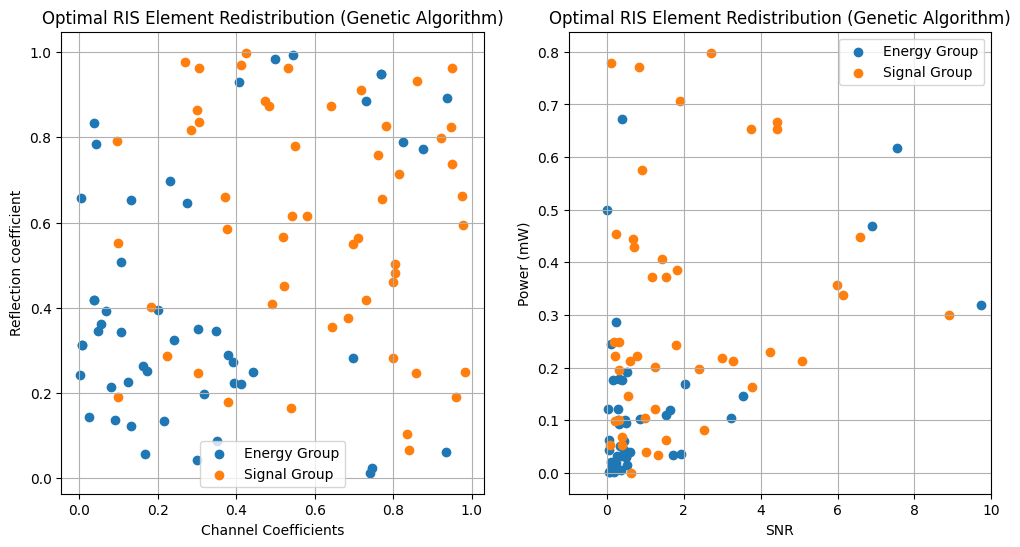

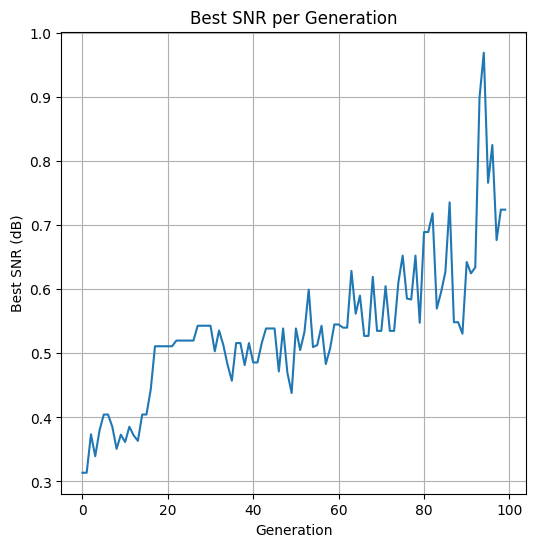

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Number of RIS elements
num_elements = 100

# Define positions
user_position = (100, 100)
base_station_position = (0, 0)
uav_position = (50, 50)  # Example UAV-RIS position

# Genetic Algorithm parameters
population_size = 100
num_generations = 100
crossover_rate = 0.8
mutation_rate = 0.1
noise_power = 0.01
path_loss_exponent = 2
incident_power = 1

# SNR with UAV-RIS (Unoptimized)
snr_uav_unoptimized = 0

def calculate_distance(point1, point2):
    return np.sqrt((point1[0] - point2[0]) ** 2 + (point1[1] - point2[1]) ** 2)


user_bs_distance = calculate_distance(user_position, base_station_position)
user_uav_distance = calculate_distance(user_position, uav_position)
bs_uav_distance = calculate_distance(base_station_position, uav_position)


# Generate channel coefficients and fading
channel_coefficients = np.random.rand(num_elements)
reflection_coefficients = np.random.rand(num_elements)
fading = np.random.rand(num_elements)
# rayleigh_fading = np.random.rayleigh(scale=1, size=num_elements)

def calculate_elements(channel_coefficients, fading, reflection_coefficients):
    snr_values = (
        channel_coefficients
        * fading
        / (channel_coefficients * (1 - fading) + noise_power)
    )

    power_values = channel_coefficients * reflection_coefficients * incident_power
    return np.column_stack((snr_values, power_values))



elements = calculate_elements(channel_coefficients, fading, reflection_coefficients)


def calculate_snr_power(channel_coefficients, fading):
    signal_power = np.sum(channel_coefficients * fading)
    energy_power = np.sum(channel_coefficients * (1 - fading))
    snr = signal_power / (energy_power + noise_power)
    power = energy_power + signal_power
    return snr, power


def generate_initial_indices(channel_coefficients, fading):
    sorted_indices = np.argsort(channel_coefficients * fading)
    energy_indices = sorted_indices[: num_elements // 2]
    signal_indices = sorted_indices[num_elements // 2 :]
    return energy_indices, signal_indices


def evaluate_fitness(energy_indices, signal_indices):
    snr, power = calculate_snr_power(
        channel_coefficients[energy_indices], fading[energy_indices]
    )
    return snr * power

def genetic_algorithm():
    # Generate initial values for energy_indices and signal_indices
    energy_indices, signal_indices = generate_initial_indices(
        channel_coefficients, fading
    )

    # Initialize population
    population = [energy_indices] * population_size

    best_snr_per_generation = []  # List to keep track of the best SNR for each generation
    overall_best_individual = None
    overall_best_snr = float('-inf')

    for i in range(num_generations):
        new_population = []
        for parent1, parent2 in zip(population[::2], population[1::2]):
            if np.random.rand() < crossover_rate:
                crossover_point = np.random.randint(1, num_elements // 2)
                child1 = np.concatenate(
                    (parent1[:crossover_point], parent2[crossover_point:])
                )
                child2 = np.concatenate(
                    (parent2[:crossover_point], parent1[crossover_point:])
                )
            else:
                child1 = parent1
                child2 = parent2

            for child in [child1, child2]:
                if np.random.rand() < mutation_rate:
                    mutation_index = np.random.randint(num_elements // 2)
                    child[mutation_index] = np.random.randint(num_elements)
            new_population.extend([child1, child2])

        population = new_population

        best_individual = max(
            population,
            key=lambda ind: evaluate_fitness(
                ind, list(set(range(num_elements)) - set(ind))
            ),
        )
        best_energy_indices = best_individual
        best_signal_indices = list(set(range(num_elements)) - set(best_individual))
        best_snr, _ = calculate_snr_power(
            channel_coefficients[best_energy_indices], fading[best_energy_indices]
        )

        best_snr_per_generation.append(best_snr)  # Append the best SNR for this generation

        # If this SNR is better than the overall best, update the overall best
        if best_snr > overall_best_snr:
            overall_best_snr = best_snr
            overall_best_individual = best_individual

        print(f"Generation {i}: Best SNR = {best_snr} dB")  # Print the best SNR for this generation

    best_energy_indices = overall_best_individual
    best_signal_indices = list(set(range(num_elements)) - set(overall_best_individual))
    best_snr, best_power = calculate_snr_power(
        channel_coefficients[best_energy_indices], fading[best_energy_indices]
    )
    if i == 0:
            global snr_uav_unoptimized
            snr_uav_unoptimized = best_snr

    return best_energy_indices, best_signal_indices, best_snr, best_power, best_snr_per_generation



# Run the Genetic Algorithm
best_energy_indices, best_signal_indices, best_snr, best_power, best_snr_per_generation = genetic_algorithm()

# Desired initial SNR without UAV-RIS in dB
desired_initial_snr_dB = 0.2

# Convert desired initial SNR from dB to linear scale
desired_initial_snr = 10 ** (desired_initial_snr_dB / 10)

# Calculate the required base station power to achieve the desired initial SNR
P_bs = (user_bs_distance**path_loss_exponent + noise_power) * desired_initial_snr

# SNR directly from the base station (Without UAV-RIS)
snr_without_ris = P_bs / (user_bs_distance** path_loss_exponent + noise_power)

# Calculate the improvement percentage
improvement_percentage = (
    (best_snr - 10 * np.log10(snr_without_ris)) / snr_without_ris * 100
)


# Print optimal groupings and their characteristics
print("Optimal Energy Group Indices:", best_energy_indices)
print("Optimal Signal Group Indices:", best_signal_indices)
print("SNR Without UAV-RIS:", 10 * np.log10(snr_without_ris), "dB")
print("SNR With UAV-RIS (Unoptimized):", snr_uav_unoptimized, "dB")
print("SNR With UAV-RIS (Optimized):", best_snr, "dB")
print("Optimal Power (Optimized):", best_power, "mW")
print("Improvement Percentage:", improvement_percentage, "%")


# Create a figure to hold both subplots
plt.figure(figsize=(12, 6))

# First subplot for Channel Coefficients and Fading
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first plot
plt.scatter(
    channel_coefficients[best_energy_indices],
    fading[best_energy_indices],
    label="Energy Group",
)
plt.scatter(
    channel_coefficients[best_signal_indices],
    fading[best_signal_indices],
    label="Signal Group",
)
plt.xlabel("Channel Coefficients")
plt.ylabel("Reflection coefficient")
plt.title("Optimal RIS Element Redistribution (Genetic Algorithm)")
plt.legend()
plt.grid(True)

# Second subplot for SNR and Power
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second plot
plt.scatter(
    elements[best_energy_indices, 0],
    elements[best_energy_indices, 1],
    label="Energy Group",
)
plt.scatter(
    elements[best_signal_indices, 0],
    elements[best_signal_indices, 1],
    label="Signal Group",
)
plt.xlabel("SNR")
plt.xlim(-1, 10)
plt.ylabel("Power (mW)")
plt.title("Optimal RIS Element Redistribution (Genetic Algorithm)")
plt.legend()
plt.grid(True)

# Show both plots
plt.show()


# Plot the graph showing the best SNR for each generation
plt.figure(figsize=(6,6))
plt.plot(best_snr_per_generation)
plt.xlabel("Generation")
plt.ylabel("Best SNR (dB)")
plt.title("Best SNR per Generation")
plt.grid(True)
plt.show()
